In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import torch
from torch.utils.data import Dataset

c:\Users\Admin\miniconda3\envs\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Here I will finetune pretrained model __DistilBert__ from transformers. 

# 1. Read data

In [2]:
df = pd.read_csv('Financial news/all-data.csv', encoding='ISO-8859-1', header=None)
df.columns = ['Label', 'Sentence']
df

,Label,Sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


# 2. EDA

In [3]:
# Shape
df.shape

(4846, 2)

In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     4846 non-null   object
 1   Sentence  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [5]:
# Check for NaN values
df.isna().sum()

Label       0
Sentence    0
dtype: int64

In [6]:
# Check for duplicates
df.duplicated().sum()

6

In [7]:
# Drop duplicates
df.drop_duplicates(inplace=True)

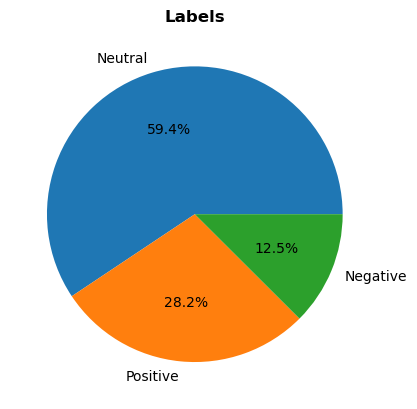

In [8]:
# Labels distribution
df['Label'].value_counts().plot(kind='pie', autopct="%1.1f%%", pctdistance=.6, labels=['Neutral', 'Positive', 'Negative'])
plt.title('Labels', fontweight='bold')
plt.ylabel('')
plt.show()

In [9]:
# Average length of all sentences
average_length = 0

for sentence in df['Sentence']:
    average_length+= len(sentence)


average_length /= len(df['Sentence'])
print(f"Average length of Sentences: {average_length:.2f}")

Average length of Sentences: 128.08


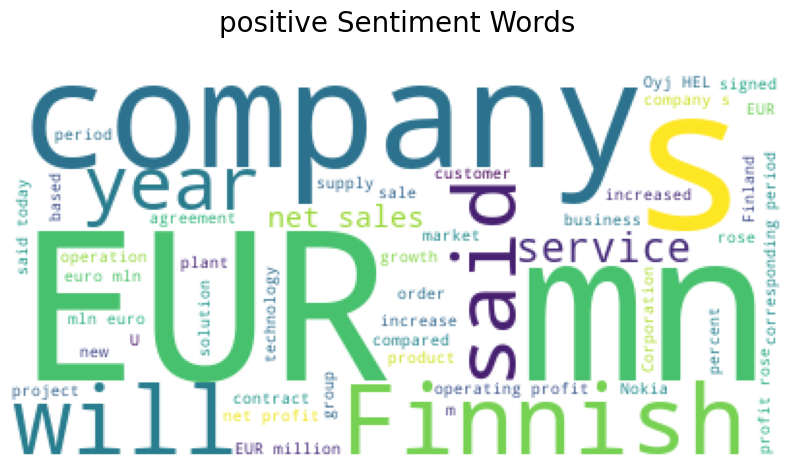

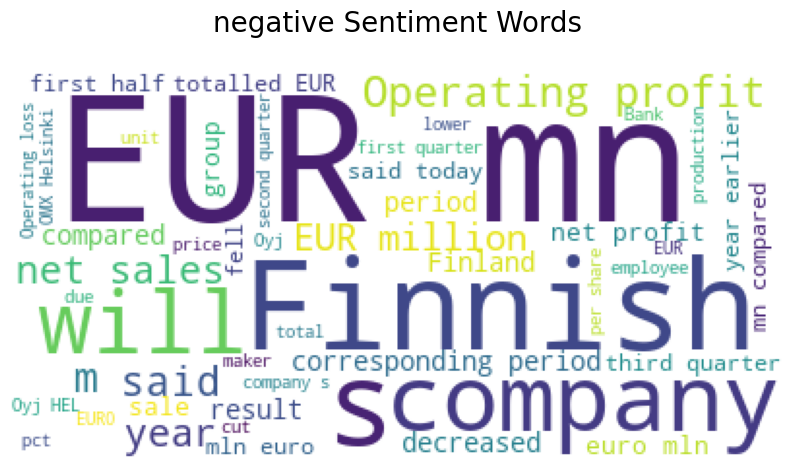

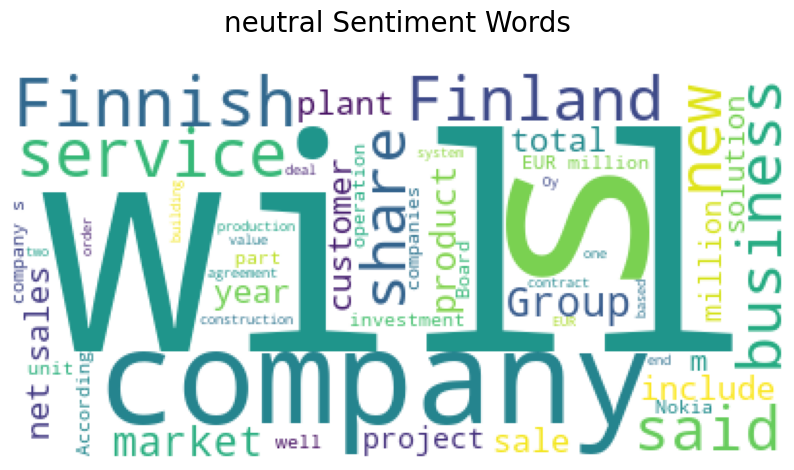

In [10]:
def wordcount_gen(df, category):

    combined_texts = " ".join([text for text in df[df.Label == category]['Sentence']])
                          
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_texts))
    plt.title(f'{category} Sentiment Words\n', fontsize=20)
    plt.axis('off')
    plt.show()
    
wordcount_gen(df, 'positive')
     
wordcount_gen(df, 'negative')
     
wordcount_gen(df, 'neutral')

# 3. Fune-Tuning DistilBert model

* ## Tokenization

In [11]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# To lists
texts = df['Sentence'].to_list()
labels = df['Label'].to_list()

# Split into train and test
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=26)

In [13]:
def tokenize_function(text):
    """Tokenize sentences"""
    return tokenizer(text, truncation=True)

# Apply the function defined above
texts_train_tokenized = tokenize_function(texts_train)
texts_test_tokenized = tokenize_function(texts_test)

print(f"Train size: {len(labels_train)}")
print(f"Test size: {len(labels_test)}")

Train size: 3872
Test size: 968


* ## Metrics

In [14]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    """Compute accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

* ## Dataset

In [15]:
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}

In [16]:
# custom BertDataset
class BertDataset(Dataset):
    def __init__(self, encodings, labels, label2id):
        self.encodings = encodings
        self.labels = [label2id[label] for label in labels]
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [17]:
# Create train and test custom datasets
train_dataset = BertDataset(encodings=texts_train_tokenized, labels=labels_train, label2id=label2id)
test_dataset = BertDataset(encodings=texts_test_tokenized, labels=labels_test, label2id=label2id)

In [18]:
train_dataset[0]

{'input_ids': tensor([  101, 21766,  6968,  3211,  2623,  2008,  2009,  2038,  2772,  2019,
          3820,  2007, 17712,  2121,  7300,  1997,  5120,  2000,  4425,  2484,
         10514,  7542, 24674,  1999,  2244,  2230,  2013,  2049, 26209,  5558,
          3211,  3131,  1999,  6435,  1012,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor(2)}

* ## Training Arguments

In [19]:
# Training Arguments
trainig_args = TrainingArguments(
    output_dir='result',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=2,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True
)

* ## Trainer

In [20]:
# Trainer
trainer = Trainer(
    model=model,
    args = trainig_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


* ## Training

In [22]:
trainer.train()

2024/05/15 18:57:24 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

                                                 
 50%|█████     | 242/484 [05:09<04:43,  1.17s/it]Checkpoint destination directory result\checkpoint-242 already exists and is non-empty.Saving will proce

{'eval_loss': 0.4011498987674713, 'eval_accuracy': 0.8450413223140496, 'eval_runtime': 25.1467, 'eval_samples_per_second': 38.494, 'eval_steps_per_second': 2.426, 'epoch': 1.0}


                                                 
100%|██████████| 484/484 [10:19<00:00,  1.17s/it]Checkpoint destination directory result\checkpoint-484 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.39116227626800537, 'eval_accuracy': 0.8512396694214877, 'eval_runtime': 25.1325, 'eval_samples_per_second': 38.516, 'eval_steps_per_second': 2.427, 'epoch': 2.0}


100%|██████████| 484/484 [10:21<00:00,  1.28s/it]

{'train_runtime': 621.6096, 'train_samples_per_second': 12.458, 'train_steps_per_second': 0.779, 'train_loss': 0.4570335514289289, 'epoch': 2.0}


TrainOutput(global_step=484, training_loss=0.4570335514289289, metrics={'train_runtime': 621.6096, 'train_samples_per_second': 12.458, 'train_steps_per_second': 0.779, 'train_loss': 0.4570335514289289, 'epoch': 2.0})

In [23]:
model = trainer.model